In [95]:
# import packages for doing time series classification form .csv files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# load the data (there is no header)

data_train = pd.read_csv(
    "project2_TS_input/ptbdb_train.csv",
    header=None,
)

# the last column is the label
y_train = data_train[187].astype(int)


# the data is the rest
X_train = data_train.iloc[:, 0:187]

# load the test data
data_test = pd.read_csv(
    "project2_TS_input/ptbdb_test.csv",
    header=None,
)

# the last column is the label
y_test = data_test[187].astype(int)

# the data is the rest
X_test = data_test.iloc[:, 0:187]

#Get the percentage of class 1 and 0 in the training set
print("Percentage of class 1 in the training set: ", y_train.sum()/len(y_train))
print("Percentage of class 0 in the training set: ", 1-y_train.sum()/len(y_train))

Percentage of class 1 in the training set:  0.7219311055751224
Percentage of class 0 in the training set:  0.2780688944248776


In [70]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


# Calculate class imbalance
def calculate_class_weights(labels, printa = False):
    class_0_number, class_1_number = torch.bincount(labels.long())
    if printa:
        print("Class 0 counts: ", class_0_number)
        print("Class 1 counts: ", class_1_number)

    weight = class_0_number / class_1_number
    if printa:
        print("Class 0 weight: ", 1)
        print("Class 1 weight: ", weight)
        
    return weight

# create a dataloader
train_data = Dataset(torch.tensor(X_train.values).float(), torch.tensor(y_train.values).float())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True) #11641
test_data = Dataset(torch.tensor(X_test.values).float(), torch.tensor(y_test.values).float())
test_loader = DataLoader(test_data, batch_size=2911, shuffle=True)

In [104]:
# create a model
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.2
        )
        self.fc = nn.Linear(187*hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        #print(out.shape)
        out = out.reshape(out.size(0), -1) 
        #print(out.shape)
        out = self.fc(out)
        #out = torch.sigmoid(out)

        return out

    def train_model(self, num_epochs, train_loader, criterion, optimizer, plot=True):
        losses = []
        # Train the model
        total_step = len(train_loader)
        for epoch in range(num_epochs):
            for i, (sequence, labels) in enumerate(train_loader):
                sequence = sequence.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = self(sequence)
                loss = criterion(
                    outputs.squeeze(), labels
                )  # Squeeze outputs to match labels shape
                losses.append(loss.item())

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i + 1) % 128 == 0:
                    print(
                        "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                            epoch + 1, num_epochs, i + 1, total_step, loss.item()
                        )
                    )

        # Plot the loss
        if plot:
            plt.plot(losses)
            plt.title("Loss")
            plt.xlabel("Step")
            plt.ylabel("Loss")
            plt.show()

        return self

    def evaluate_model(self, test_loader, threshold=0.5, plot_confusion_matrix=False):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for sequence, labels in test_loader:
                sequence = sequence.to(device)
                labels = labels.to(device)
                outputs = self(sequence)
                predicted = (outputs > threshold).float()
                total += labels.size(0)
                correct += (predicted == labels.view(-1, 1)).sum().item()

            print(
                "Accuracy of the model on the test set: {} %".format(
                    100 * correct / total
                )
            )

            if plot_confusion_matrix:
                y_true = labels.cpu().numpy()
                y_pred = predicted.cpu().numpy()
                cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                            display_labels=['Class 0', 'Class 1'], 
                                            cmap='Blues', 
                                            normalize=None)
 
                print(classification_report(y_true, y_pred))

        return self

# unidirectional  LSTM 

In [105]:
# Hyperparameters
input_size = 1
hidden_size = 10
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 10

# Calculate class weights
class_weights = calculate_class_weights(torch.tensor(y_train.values))

# Convert class weights to tensor (uncomment this if you want to use class weights)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Set class weights to 1 (uncomment this if you don't want to use class weights)
# class_weights_tensor = torch.tensor(1, dtype=torch.float32).to(device)


print("Class weights tensor: ", class_weights_tensor)

Class weights tensor:  tensor(0.3852)


/var/folders/jj/m28xy22x5w74b624rj27hpn80000gn/T/ipykernel_44715/4158824606.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


Epoch [1/10], Step [128/182], Loss: 0.3814
Epoch [2/10], Step [128/182], Loss: 0.3496
Epoch [3/10], Step [128/182], Loss: 0.4316
Epoch [4/10], Step [128/182], Loss: 0.3431
Epoch [5/10], Step [128/182], Loss: 0.4259
Epoch [6/10], Step [128/182], Loss: 0.4441
Epoch [7/10], Step [128/182], Loss: 0.3274
Epoch [8/10], Step [128/182], Loss: 0.2712
Epoch [9/10], Step [128/182], Loss: 0.2254
Epoch [10/10], Step [128/182], Loss: 0.3784


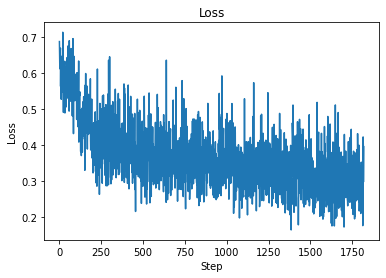

LSTMBinaryClassifier(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1870, out_features=1, bias=True)
)

In [106]:
# Create model instance
model = LSTMBinaryClassifier(input_size, hidden_size, num_layers, output_size).to(
    device
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train_model(num_epochs, train_loader, criterion, optimizer)



Accuracy of the model on the test set: 87.18653383716936 %
              precision    recall  f1-score   support

         0.0       0.73      0.84      0.79       809
         1.0       0.94      0.88      0.91      2102

    accuracy                           0.87      2911
   macro avg       0.84      0.86      0.85      2911
weighted avg       0.88      0.87      0.87      2911



LSTMBinaryClassifier(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1870, out_features=1, bias=True)
)

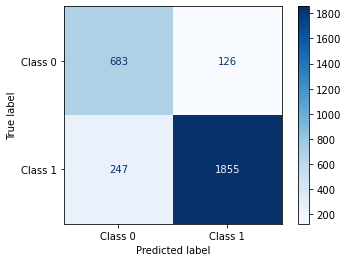

In [107]:
# Evaluate the model
model.evaluate_model(test_loader, threshold=0.5, plot_confusion_matrix=True)

# bidirectional LSTM

In [98]:
class biLSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional):
        super(biLSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=bidirectional
        )
        self.fc = nn.Linear(2*187*hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x)
        #print(out.shape)
        out = out.reshape(out.size(0), -1) 
        #print(out.shape)
        out = self.fc(out)
        #out = torch.sigmoid(out)

        return out

    def train_model(self, num_epochs, train_loader, criterion, optimizer, plot=True):
        losses = []
        # Train the model
        total_step = len(train_loader)
        for epoch in range(num_epochs):
            for i, (sequence, labels) in enumerate(train_loader):
                sequence = sequence.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = self(sequence)
                loss = criterion(
                    outputs.squeeze(), labels
                )  # Squeeze outputs to match labels shape
                losses.append(loss.item())

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i + 1) % 128 == 0:
                    print(
                        "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                            epoch + 1, num_epochs, i + 1, total_step, loss.item()
                        )
                    )

        # Plot the loss
        if plot:
            plt.plot(losses)
            plt.title("Loss")
            plt.xlabel("Step")
            plt.ylabel("Loss")
            plt.show()

        return self

    def evaluate_model(self, test_loader, threshold=0.5, plot_confusion_matrix=False):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for sequence, labels in test_loader:
                sequence = sequence.to(device)
                labels = labels.to(device)
                outputs = self(sequence)
                predicted = (outputs > threshold).float()
                total += labels.size(0)
                correct += (predicted == labels.view(-1, 1)).sum().item()

            print(
                "Accuracy of the model on the test set: {} %".format(
                    100 * correct / total
                )
            )

            if plot_confusion_matrix:
                y_true = labels.cpu().numpy()
                y_pred = predicted.cpu().numpy()
                cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                            display_labels=['Class 0', 'Class 1'], 
                                            cmap='Blues', 
                                            normalize=None)
 
                print(classification_report(y_true, y_pred))

        return self

In [99]:
# Hyperparameters
input_size = 1
hidden_size = 10
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 10

Epoch [1/10], Step [128/182], Loss: 0.4563
Epoch [2/10], Step [128/182], Loss: 0.4236
Epoch [3/10], Step [128/182], Loss: 0.4379
Epoch [4/10], Step [128/182], Loss: 0.4436
Epoch [5/10], Step [128/182], Loss: 0.2759
Epoch [6/10], Step [128/182], Loss: 0.3255
Epoch [7/10], Step [128/182], Loss: 0.2203
Epoch [8/10], Step [128/182], Loss: 0.2787
Epoch [9/10], Step [128/182], Loss: 0.1746
Epoch [10/10], Step [128/182], Loss: 0.2255


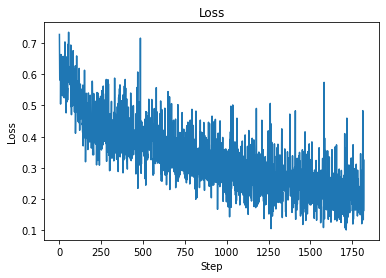

biLSTMBinaryClassifier(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=3740, out_features=1, bias=True)
)

In [108]:
# Create model instance
model2 = biLSTMBinaryClassifier(input_size, hidden_size, num_layers, output_size,bidirectional=True).to(
    device
)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# Train the model
model2.train_model(num_epochs, train_loader, criterion, optimizer)



Accuracy of the model on the test set: 91.58364823084851 %
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       809
         1.0       0.96      0.92      0.94      2102

    accuracy                           0.92      2911
   macro avg       0.89      0.91      0.90      2911
weighted avg       0.92      0.92      0.92      2911



biLSTMBinaryClassifier(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=3740, out_features=1, bias=True)
)

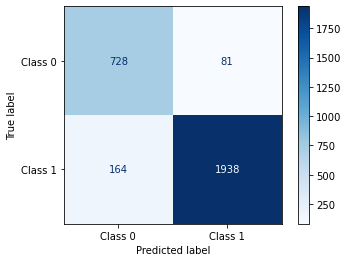

In [109]:
# Evaluate the model
model2.evaluate_model(test_loader, threshold=0.5, plot_confusion_matrix=True)